In [323]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

In [324]:
df = pd.read_csv('data/daily_total.csv')
df.index = [datetime.strptime(x, '%Y-%m-%d') for x in df['DATE']]
df = df[df.index > '2022-08-10']
df = df.reindex(pd.date_range(min(df['DATE']), max(df['DATE'])), fill_value=0).drop('DATE', axis=1)
column = 'SECONDSSPENT'
df

,USERCOUNT,SECONDSSPENT,QUANTITY,VOLUME,WEIGHT,PRICE
2022-08-16,15,24864,1564,5.510447,606.628000,7714.46
2022-08-17,46,648639,153271,900.823306,87245.837728,731227.04
2022-08-18,72,1535976,353781,2687.981897,247269.820740,2135600.74
2022-08-19,70,1253113,395921,2944.799061,262781.058485,2136707.30
2022-08-20,6,67002,593,14.290446,975.280591,14861.86
...,...,...,...,...,...,...
2023-09-25,101,1171721,854092,2678.434373,292547.191456,1875797.61
2023-09-26,110,1249771,1016887,3483.392239,371822.547589,2318629.60
2023-09-27,104,1257222,939123,2998.222002,300263.198492,1850064.42
2023-09-28,109,1339688,1224169,3863.465093,384720.606181,2390796.27


In [325]:
df.resample("YS").sum().round(2).corr().style.background_gradient(cmap='coolwarm')

,USERCOUNT,SECONDSSPENT,QUANTITY,VOLUME,WEIGHT,PRICE
USERCOUNT,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000
SECONDSSPENT,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000
QUANTITY,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000
VOLUME,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000
WEIGHT,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000
PRICE,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000


In [326]:
# correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,USERCOUNT,SECONDSSPENT,QUANTITY,VOLUME,WEIGHT,PRICE
USERCOUNT,1.000000,0.942946,0.845696,0.887294,0.899947,0.665914
SECONDSSPENT,0.942946,1.000000,0.884744,0.911248,0.934875,0.686964
QUANTITY,0.845696,0.884744,1.000000,0.860263,0.928506,0.601137
VOLUME,0.887294,0.911248,0.860263,1.000000,0.976150,0.727141
WEIGHT,0.899947,0.934875,0.928506,0.976150,1.000000,0.707397
PRICE,0.665914,0.686964,0.601137,0.727141,0.707397,1.000000


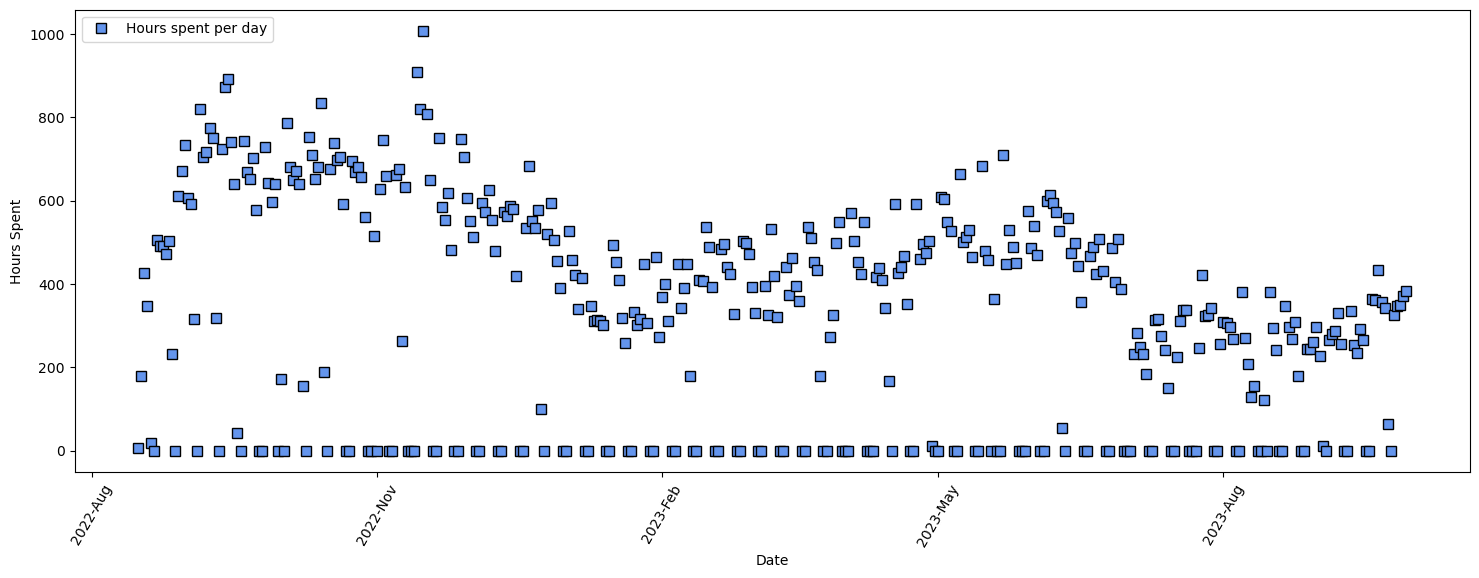

In [327]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
ax.plot(df.index, df[column] / 3600, linestyle='none', marker='s',
        markerfacecolor='cornflowerblue', 
        markeredgecolor='black',
        markersize=7,
        label='Hours spent per day')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.set_xlabel('Date')
ax.set_ylabel('Hours Spent')
plt.xticks(rotation=60)
ax.legend(loc='upper left')

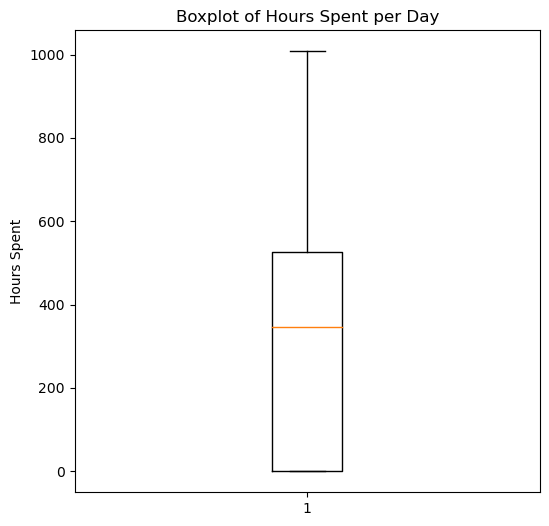

In [328]:
# boxplot of hours spent per day
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.boxplot(df[column] / 3600)
ax.set_ylabel('Hours Spent')
ax.set_title('Boxplot of Hours Spent per Day')
plt.show()

In [329]:
df[column].sort_values(ascending=False).head(10)

2022-11-16    3628515
2022-11-14    3272069
2022-09-14    3213480
2022-09-13    3144026
2022-10-14    3006732
2022-11-15    2951189
2022-09-05    2948984
2022-11-17    2911377
2022-10-03    2834680
2022-09-08    2789033
Name: SECONDSSPENT, dtype: int64

In [330]:
# # remove outliers
# df = df[df['SECONDSSPENT'] / 3600 < 2000]

# fig, ax = plt.subplots()
# fig.set_size_inches(18, 6)
# ax.plot(df.index, df['SECONDSSPENT'] / 3600, linestyle='none', marker='s',
#         markerfacecolor='cornflowerblue', 
#         markeredgecolor='black',
#         markersize=7,
#         label='Hours spent per day')
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# ax.set_xlabel('Date')
# ax.set_ylabel('Hours Spent')
# plt.xticks(rotation=60)
# ax.legend(loc='upper left')

In [331]:
corr_list = []

for i in range(1, len(df) - 1):
    corr_list.append(np.corrcoef(df[column][i:], df[column][: -i])[0, 1])

# index and correlation coefficient dataframe
corr_df = pd.DataFrame({'Lag': list(range(1, len(df) - 1)), 'Correlation': corr_list})
corr_df = corr_df.sort_values(by='Correlation', ascending=False)
print(corr_df.head(10).to_string(index=False))

 Lag  Correlation
 408     1.000000
 407     0.959225
 406     0.847556
 392     0.841644
 378     0.830175
 385     0.825541
 371     0.823189
   7     0.799279
 175     0.783499
 161     0.780194


In [332]:
def find_period(signal, corr_threshold=0.2):
    acf = np.correlate(signal, signal, 'full')[-len(signal):]
    inflection = np.diff(np.sign(np.diff(acf)))
    peaks = (inflection < 0).nonzero()[0] + 1
    if len(peaks) == 0:
        print('No seasonality found')
        return 1, 0
    period = peaks[acf[peaks].argmax()]
    corr = np.corrcoef(df[column][period:], df[column][: -period])[0, 1]
    if corr < corr_threshold or period == 1:
        print('No seasonality found')
        return 1, corr
    return period, corr

period, corr = find_period(df[column])
print('Period:', period, '\nCorrelation:', corr)

Period: 7 
Correlation: 0.7992788239524425


In [333]:
# log transformation
df_log = df.copy()
df_log[column] = df_log[column].replace(0, 3600)
# df_log[column] = df_log[column].replace(0, np.nan).interpolate(method='cubicspline')
# df_log[column] = np.log(df_log[column]).interpolate(method='cubicspline')

In [334]:
df_log[column].isna().sum()

0

In [335]:
# deseaonalize
df_log['Seasonal'] = seasonal_decompose(df_log[column], model='additive', period=period).seasonal
df_log['DS'] = seasonal_decompose(df_log[column], model='additive', period=period).trend

# linear regression with deseasonalized SECONDSSPENT
reg_df = df_log[df_log['DS'].notna()]
endog = np.array(reg_df['DS'])
exog = sm.add_constant(np.array(reg_df.index.dayofyear))
model = sm.OLS(endog, exog)
results = model.fit()
# print(results.summary())

initial_level = results.params[0]
initial_trend = results.params[1]
df_log['DS'] = initial_level + initial_trend * np.array(df_log.index.dayofyear)
df_log['Seasonal Factor'] = df_log[column] / df_log['DS']

initial_seasonal = []
if period == 1:
    initial_seasonal = [1]
else:
    for i in range(period):
        initial_seasonal.append(df_log.iloc[i::period].mean()['Seasonal Factor'])

print(initial_level)
print(initial_trend)
print(initial_seasonal)


880399.8806937146
1642.1824163156577
[1.3982961804064262, 1.4530038904630804, 1.4080216033090065, 1.1336385870770358, 0.09241373514218783, 0.003095768355233709, 1.4690930300092613]


In [336]:
seasonal_periods = period
alpha = 0.5
beta = 0.01
gamma = 0.01

winters_model = ExponentialSmoothing(
    df_log[column],
    trend="add",
    seasonal="mul",
    seasonal_periods=seasonal_periods,
    initialization_method="known",
    initial_level=initial_level,
    initial_trend=initial_trend,
    initial_seasonal=initial_seasonal
).fit(smoothing_level=alpha,
      smoothing_trend=beta,
      smoothing_seasonal=gamma,
      )

last_day = df_log.index[-1]

num_periods = period
df_log["FORECAST"] = winters_model.fittedvalues
forecast = pd.DataFrame(
    {'FORECAST': list(winters_model.forecast(num_periods))},
    index=pd.date_range(start=last_day + pd.DateOffset(days=1), periods=num_periods, freq='D')
)

df_forecast = df_log.append(forecast)
# df_forecast[[column,'FORECAST']] = np.exp(df_forecast[[column,'FORECAST']])
df_forecast.tail(period*2)

,USERCOUNT,SECONDSSPENT,QUANTITY,VOLUME,WEIGHT,PRICE,Seasonal,DS,Seasonal Factor,FORECAST
2023-09-23,1.0,227385.0,0.0,0.000000,0.000000,0.00,-1.073142e+06,1.317220e+06,0.172625,7.955761e+04
2023-09-24,0.0,3600.0,0.0,0.000000,0.000000,0.00,-1.188879e+06,1.318863e+06,0.002730,8.824139e+03
2023-09-25,101.0,1171721.0,854092.0,2678.434373,292547.191456,1875797.61,5.514296e+05,1.320505e+06,0.887328,2.198067e+06
2023-09-26,110.0,1249771.0,1016887.0,3483.392239,371822.547589,2318629.60,4.973969e+05,1.322147e+06,0.945259,1.578430e+06
2023-09-27,104.0,1257222.0,939123.0,2998.222002,300263.198492,1850064.42,5.536739e+05,1.323789e+06,0.949715,1.449042e+06
2023-09-28,109.0,1339688.0,1224169.0,3863.465093,384720.606181,2390796.27,4.917911e+05,1.325431e+06,1.010756,1.256503e+06
2023-09-29,107.0,1381580.0,1109442.0,3556.001516,377380.162562,2196789.75,1.677300e+05,1.327073e+06,1.041073,1.027457e+06
2023-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.682869e+04
2023-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.854654e+03
2023-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.716844e+06


In [337]:
df_forecast['DATE'] = df_forecast.index
df_forecast[['DATE', 'SECONDSSPENT', 'FORECAST']].to_csv('data/hw_forecast.csv', index=False)

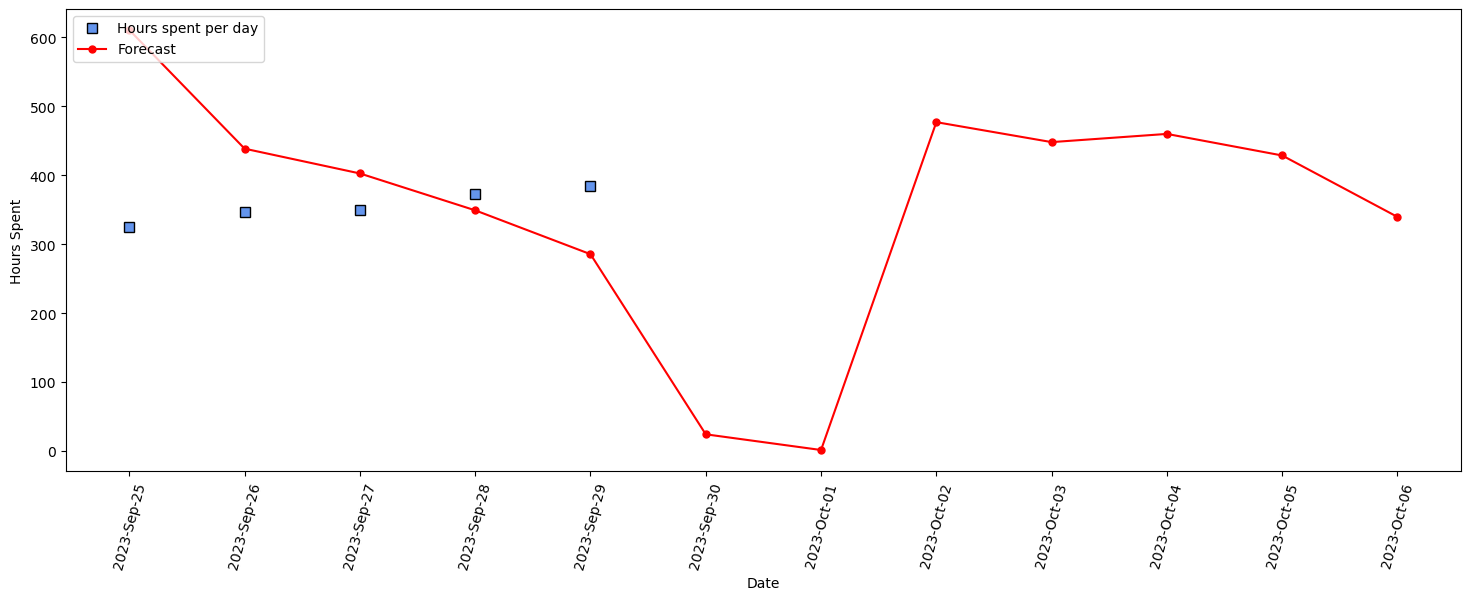

In [341]:
last_day = df.index[-1]
# df_plot = df_forecast[df_forecast.index >= last_day - pd.to_timedelta("60day")]
# df_plot = df_forecast[df_forecast.index <= last_day]
# last sixty observations
df_plot = df_forecast[-12:]

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
ax.plot(df_plot.index, df_plot[column] / 3600, 
        linestyle='none', 
        marker='s',
        markerfacecolor='cornflowerblue', 
        markeredgecolor='black',
        markersize=7,
        label='Hours spent per day')
ax.plot(df_plot.index, df_plot['FORECAST'] / 3600, 
        linestyle='-',
        marker='o',
        markersize=5,
        color='red',
        label='Forecast')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b-%d'))
ax.set_xlabel('Date')
ax.set_ylabel('Hours Spent')
plt.xticks(rotation=75)
ax.legend(loc='upper left')
plt.show()

In [342]:
# mean absolute error
mae = np.mean(np.abs(df_plot[column] - df_plot['FORECAST'])) / 3600
print('MAE: {:.3f}'.format(mae))

# root mean squared error
mse = np.sqrt(np.mean(((df_plot[column] - df_plot['FORECAST'])) ** 2)) / 3600
print('RMSE: {:.3f}'.format(mse))

MAE: 110.230
RMSE: 143.292


In [319]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing


def _get_period(data: pd.Series, corr_threshold: float = 0.2):
    acf = np.correlate(data, data, 'full')[-len(data):]
    inflection = np.diff(np.sign(np.diff(acf)))
    peaks = (inflection < 0).nonzero()[0] + 1
    if len(peaks) == 0:
        print('No seasonality found')
        return 1, 0
    period = peaks[acf[peaks].argmax()]
    corr = np.corrcoef(data[period:], data[: -period])[0, 1]
    if corr < corr_threshold or period == 1:
        print('No seasonality found')
        return 1, corr
    return period, corr


def _get_initial_params(df: pd.DataFrame, column: str, log: bool = True):
    period, corr = _get_period(df[column])

    df_log = df.copy()
    if log:
        df_log[column] = df_log[column].replace(0, np.nan).interpolate(method='cubicspline')
        df_log[column] = np.log(df_log[column])
    else:
        df_log[column] = df_log[column].replace(0, 3600)

    # deseaonalize
    df_log['Seasonal'] = seasonal_decompose(df_log[column], model='additive', period=period).seasonal
    df_log['DS'] = seasonal_decompose(df_log[column], model='additive', period=period).trend

    # linear regression with deseasonalized SECONDSSPENT
    reg_df = df_log[df_log['DS'].notna()]
    endog = np.array(reg_df['DS'])
    exog = sm.add_constant(np.array(reg_df.index.dayofyear))
    model = sm.OLS(endog, exog)
    results = model.fit()
    # print(results.summary())

    initial_level = results.params[0]
    initial_trend = results.params[1]
    df_log['DS'] = initial_level + initial_trend * np.array(df_log.index.dayofyear)
    df_log['Seasonal Factor'] = df_log[column] / df_log['DS']

    initial_seasonal = []
    if period == 1:
        initial_seasonal = [1]
    else:
        for i in range(period):
            initial_seasonal.append(df_log.iloc[i::period].mean()['Seasonal Factor'])
    
    return period, initial_level, initial_trend, initial_seasonal


def forecast(df: pd.DataFrame, 
            column: str, 
            log: bool = False,
            alpha: float = 0.5, 
            beta: float =  0.01, 
            gamma: float = 0.01):
    
    period, initial_level, initial_trend, initial_seasonal = _get_initial_params(df, column, log)
    print('Period: {}'.format(period))
    print('Initial Level: {}'.format(initial_level))
    print('Initial Trend: {}'.format(initial_trend))
    print('Initial Seasonal: {}'.format(initial_seasonal))
    
    df_log = df.copy()
    if log:
        df_log[column] = df_log[column].replace(0, np.nan).interpolate(method='cubicspline')
        df_log[column] = np.log(df_log[column])
    else:
        df_log[column] = df_log[column].replace(0, 3600)
    
    if period != 1:
        winters_model = ExponentialSmoothing(
        df_log[column],
        trend="add",
        seasonal="mul",
        seasonal_periods=period,
        initialization_method="known",
        initial_level=initial_level,
        initial_trend=initial_trend,
        initial_seasonal=initial_seasonal
    ).fit(smoothing_level=alpha,
        smoothing_trend=beta,
        smoothing_seasonal=gamma,
        )
    else:
        winters_model = ExponentialSmoothing(
        df_log[column],
        trend="add",
        seasonal=None,
        initialization_method="known",
        initial_level=initial_level,
        initial_trend=initial_trend
    ).fit(smoothing_level=alpha,
        smoothing_trend=beta
        )

    last_day = df_log.index[-1]
    num_periods = period
    df_log["FORECAST"] = winters_model.fittedvalues
    forecast = pd.DataFrame(
        {'FORECAST': list(winters_model.forecast(num_periods))},
        index=pd.date_range(start=last_day + pd.DateOffset(days=1), periods=num_periods, freq='D')
    )

    df_forecast = df_log.append(forecast)
    if log:
        df_forecast[[column,'FORECAST']] = np.exp(df_forecast[[column,'FORECAST']])
    print(df_forecast.tail(period*2))

    return df_forecast


def plot_forecast(df: pd.DataFrame, column: str, title: str = ''):
    df_forecast = forecast(df, column)
    # df_plot = df_forecast[df_forecast.index >= '2022-08-10']
    df_plot = df_forecast[-66:]

    test_size = int(len(df_plot) * 0.2)
    test = df_plot[-test_size:]
    mae = np.mean(np.abs(test[column] - test['FORECAST'])) / 3600
    print('MAE: {:.3f}'.format(mae))

    fig, ax = plt.subplots()
    fig.set_size_inches(18, 6)
    ax.plot(df_plot.index, df_plot[column] / 3600, 
            linestyle='none', 
            marker='s',
            markerfacecolor='cornflowerblue', 
            markeredgecolor='black',
            markersize=7,
            label='Hours spent per day')
    ax.plot(df_plot.index, df_plot['FORECAST'] / 3600, 
            linestyle='-',
            marker='o',
            markersize=5,
            color='red',
            label='Forecast')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b-%d'))
    ax.set_xlabel('Date')
    ax.set_ylabel('Hours Spent')
    plt.xticks(rotation=75)
    ax.legend(loc='upper left')
    plt.show()



In [321]:
df.shape

(2093, 8)

True
DP2
Period: 6
Initial Level: 465639.55131241574
Initial Trend: 1335.7872088668107
Initial Seasonal: [1.0529221057808442, 1.0483772883104854, 1.0052696071409164, 0.9075781433738024, 0.9115098908721471, 1.0405704176804087]
                  DATE TEAMNAME  USERCOUNT  SECONDSSPENT  QUANTITY  \
2023-09-23  2023-09-23      DP2        1.0      227385.0       0.0   
2023-09-25  2023-09-25      DP2       43.0      454060.0  263427.0   
2023-09-26  2023-09-26      DP2       46.0      633332.0  204334.0   
2023-09-27  2023-09-27      DP2       46.0      611887.0  261812.0   
2023-09-28  2023-09-28      DP2       47.0      634110.0  220623.0   
2023-09-29  2023-09-29      DP2       46.0      735097.0  255841.0   
2023-09-30         NaN      NaN        NaN           NaN       NaN   
2023-10-01         NaN      NaN        NaN           NaN       NaN   
2023-10-02         NaN      NaN        NaN           NaN       NaN   
2023-10-03         NaN      NaN        NaN           NaN       NaN   
2023

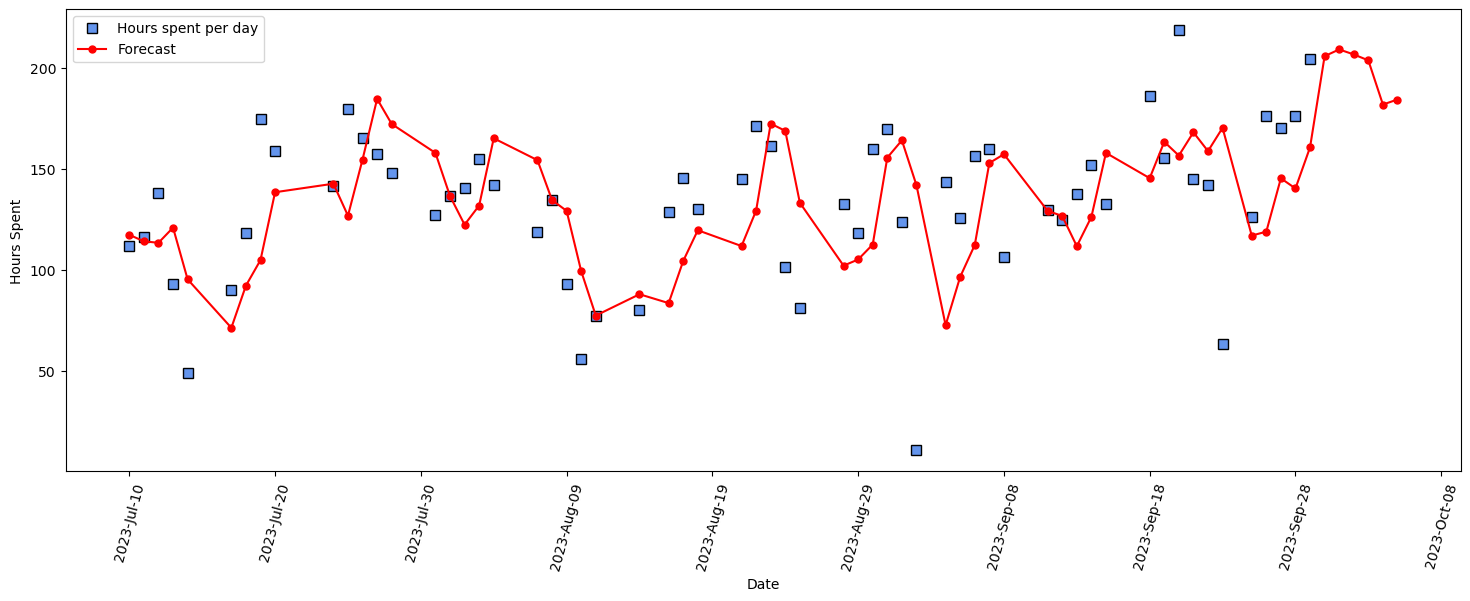

DP1
Period: 6
Initial Level: 691083.519761648
Initial Trend: 629.6388738308762
Initial Seasonal: [1.053547066423733, 1.0364554344050907, 1.0309000837704487, 0.9579996927727599, 0.8690268209285505, 1.0080451036027183]
                  DATE TEAMNAME  USERCOUNT  SECONDSSPENT  QUANTITY  \
2023-09-23  2023-09-23      DP1        0.0        3600.0       0.0   
2023-09-25  2023-09-25      DP1       51.0      698325.0  297376.0   
2023-09-26  2023-09-26      DP1       55.0      576097.0  388098.0   
2023-09-27  2023-09-27      DP1       53.0      621429.0  338778.0   
2023-09-28  2023-09-28      DP1       53.0      670896.0  398947.0   
2023-09-29  2023-09-29      DP1       50.0      629794.0  386483.0   
2023-09-30         NaN      NaN        NaN           NaN       NaN   
2023-10-01         NaN      NaN        NaN           NaN       NaN   
2023-10-02         NaN      NaN        NaN           NaN       NaN   
2023-10-03         NaN      NaN        NaN           NaN       NaN   
2023-10-04   

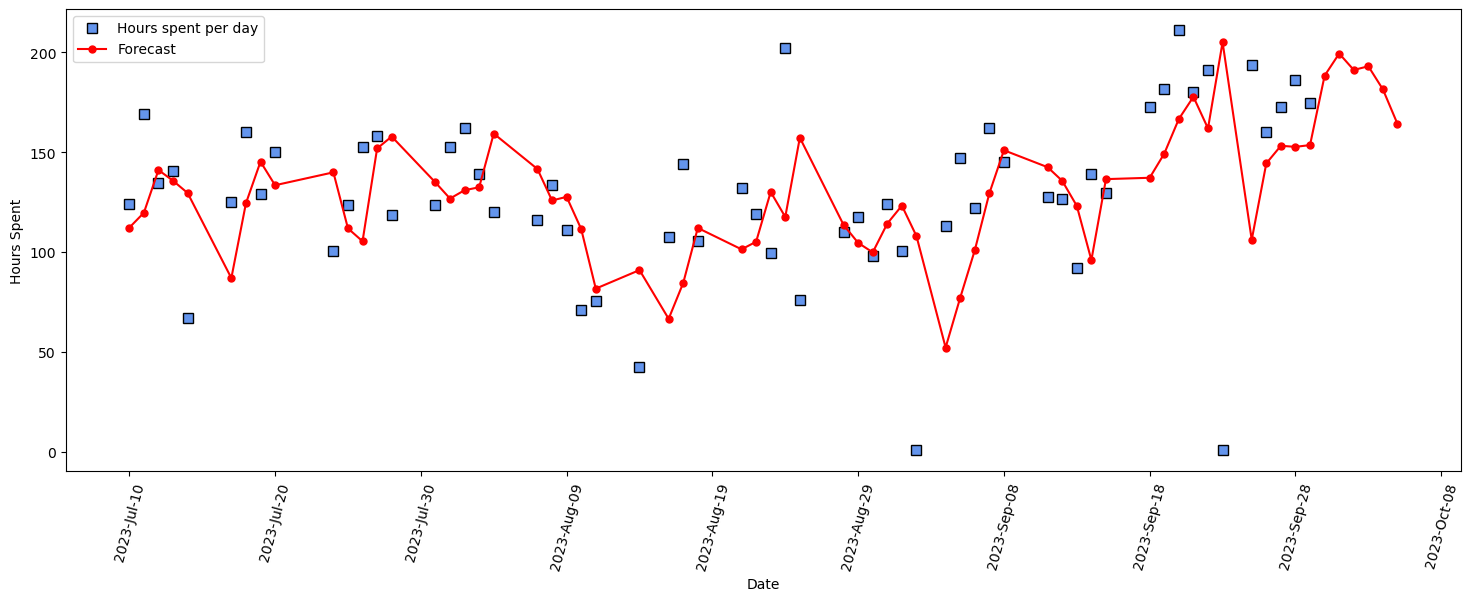

HP1
Period: 5
Initial Level: 3541.229182584877
Initial Trend: 6.286838047745682
Initial Seasonal: [0.9722277544264223, 1.1801040972512549, 0.8588320449313144, 0.9271473471339455, 1.033532067448204]
                  DATE TEAMNAME  USERCOUNT  SECONDSSPENT  QUANTITY  \
2023-09-25  2023-09-25      HP1        0.0        3600.0       0.0   
2023-09-26  2023-09-26      HP1        1.0        2926.0   57558.0   
2023-09-27  2023-09-27      HP1        1.0         889.0   53843.0   
2023-09-28  2023-09-28      HP1        1.0         275.0   19455.0   
2023-09-29  2023-09-29      HP1        1.0         784.0   46145.0   
2023-09-30         NaN      NaN        NaN           NaN       NaN   
2023-10-01         NaN      NaN        NaN           NaN       NaN   
2023-10-02         NaN      NaN        NaN           NaN       NaN   
2023-10-03         NaN      NaN        NaN           NaN       NaN   
2023-10-04         NaN      NaN        NaN           NaN       NaN   

                VOLUME        W

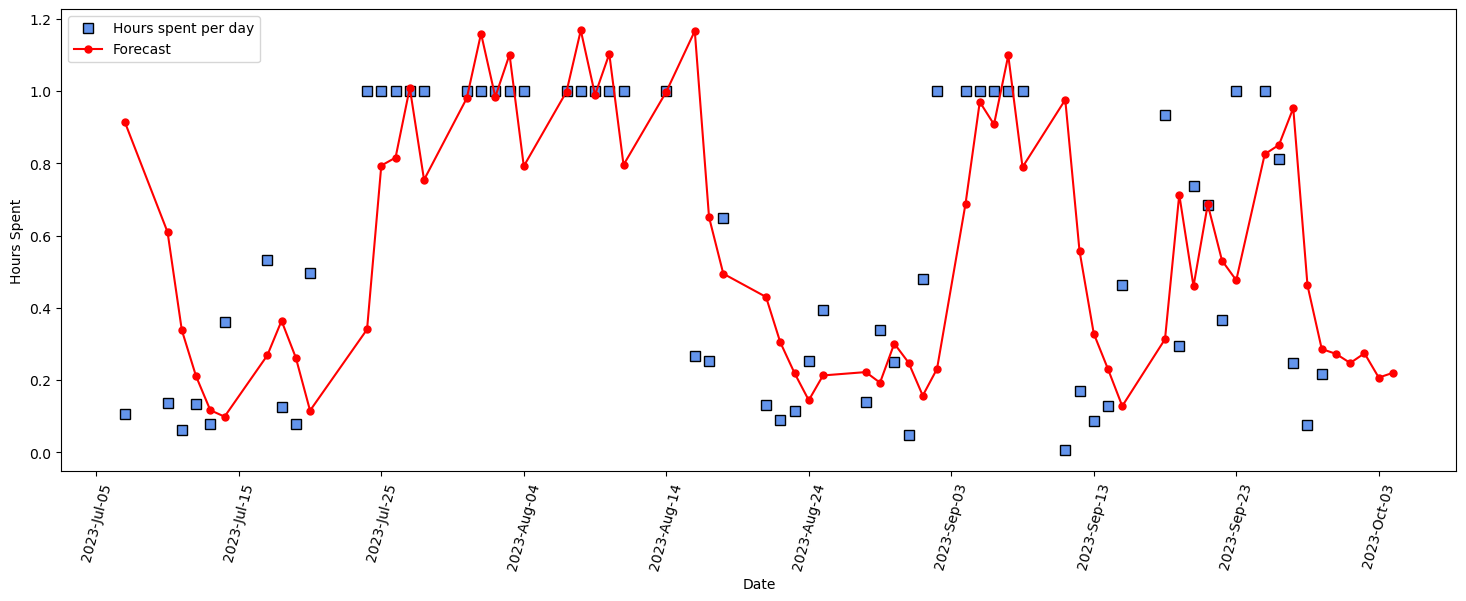

DD
No seasonality found
Period: 1
Initial Level: 104999.79540886934
Initial Trend: -118.49064975117798
Initial Seasonal: [1]
                  DATE TEAMNAME  USERCOUNT  SECONDSSPENT  QUANTITY  \
2023-09-29  2023-09-29       DD        7.0        6695.0  332128.0   
2023-09-30         NaN      NaN        NaN           NaN       NaN   

                 VOLUME         WEIGHT      PRICE      FORECAST  
2023-09-29  1090.899987  115141.810667  770403.11  23680.268001  
2023-09-30          NaN            NaN        NaN  14666.817641  
MAE: 7.699


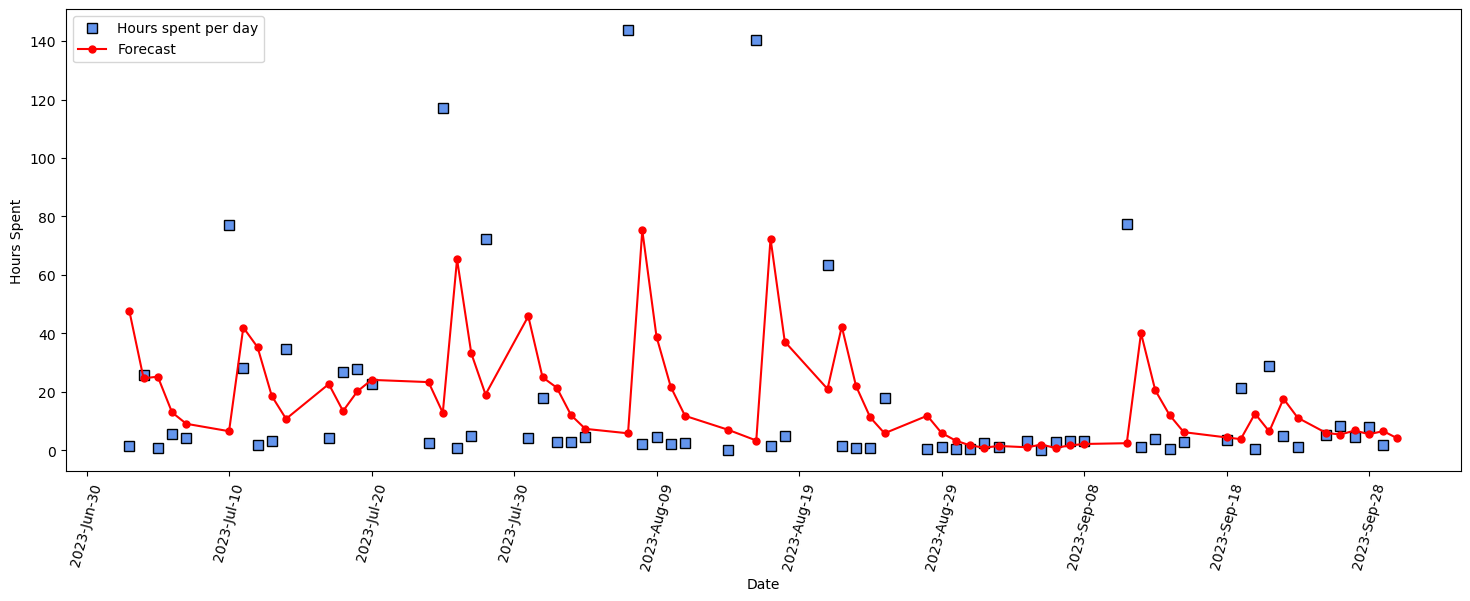

HP2
Period: 6
Initial Level: 12054.399363906577
Initial Trend: 20.904066419332224
Initial Seasonal: [1.150234528886926, 1.0326373520372176, 0.9109786966315858, 0.9181492014791918, 0.8620369532444911, 1.0588215410040722]
                  DATE TEAMNAME  USERCOUNT  SECONDSSPENT  QUANTITY  \
2023-09-23  2023-09-23      HP2        0.0        3600.0       0.0   
2023-09-25  2023-09-25      HP2        1.0         785.0   46080.0   
2023-09-26  2023-09-26      HP2        3.0        7178.0   96688.0   
2023-09-27  2023-09-27      HP2        2.0        6901.0   88725.0   
2023-09-28  2023-09-28      HP2        2.0        5959.0  144051.0   
2023-09-29  2023-09-29      HP2        3.0        9210.0   88845.0   
2023-09-30         NaN      NaN        NaN           NaN       NaN   
2023-10-01         NaN      NaN        NaN           NaN       NaN   
2023-10-02         NaN      NaN        NaN           NaN       NaN   
2023-10-03         NaN      NaN        NaN           NaN       NaN   
2023-10-04

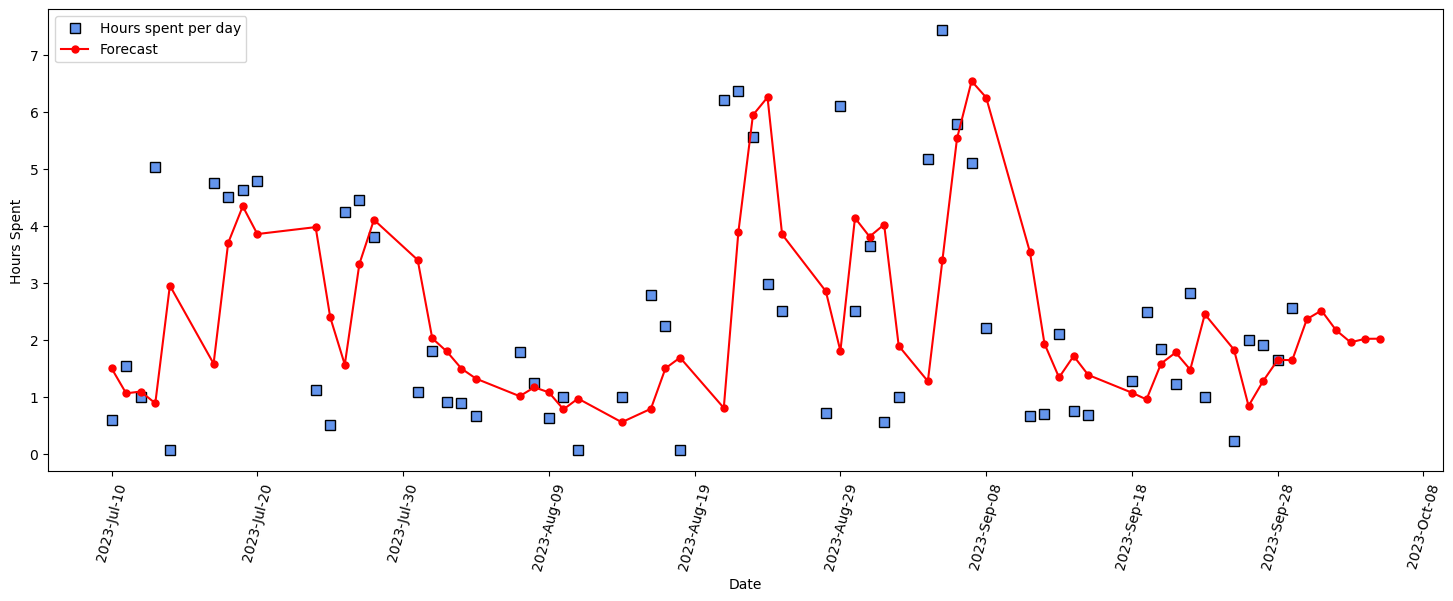

HD
Period: 3
Initial Level: 2523.5357217750025
Initial Trend: 20.71532591548568
Initial Seasonal: [0.9724887565266213, 0.9430029196312779, 1.0636374087596359]
                  DATE TEAMNAME  USERCOUNT  SECONDSSPENT  QUANTITY  VOLUME  \
2023-09-27  2023-09-27       HD        0.0        3600.0       0.0     0.0   
2023-09-28  2023-09-28       HD        0.0        3600.0       0.0     0.0   
2023-09-29  2023-09-29       HD        0.0        3600.0       0.0     0.0   
2023-09-30         NaN      NaN        NaN           NaN       NaN     NaN   
2023-10-01         NaN      NaN        NaN           NaN       NaN     NaN   
2023-10-02         NaN      NaN        NaN           NaN       NaN     NaN   

            WEIGHT  PRICE     FORECAST  
2023-09-27     0.0    0.0  3793.673938  
2023-09-28     0.0    0.0  3529.104688  
2023-09-29     0.0    0.0  3460.844515  
2023-09-30     NaN    NaN  3791.193215  
2023-10-01     NaN    NaN  3622.968261  
2023-10-02     NaN    NaN  3517.630420  
MAE: 0.

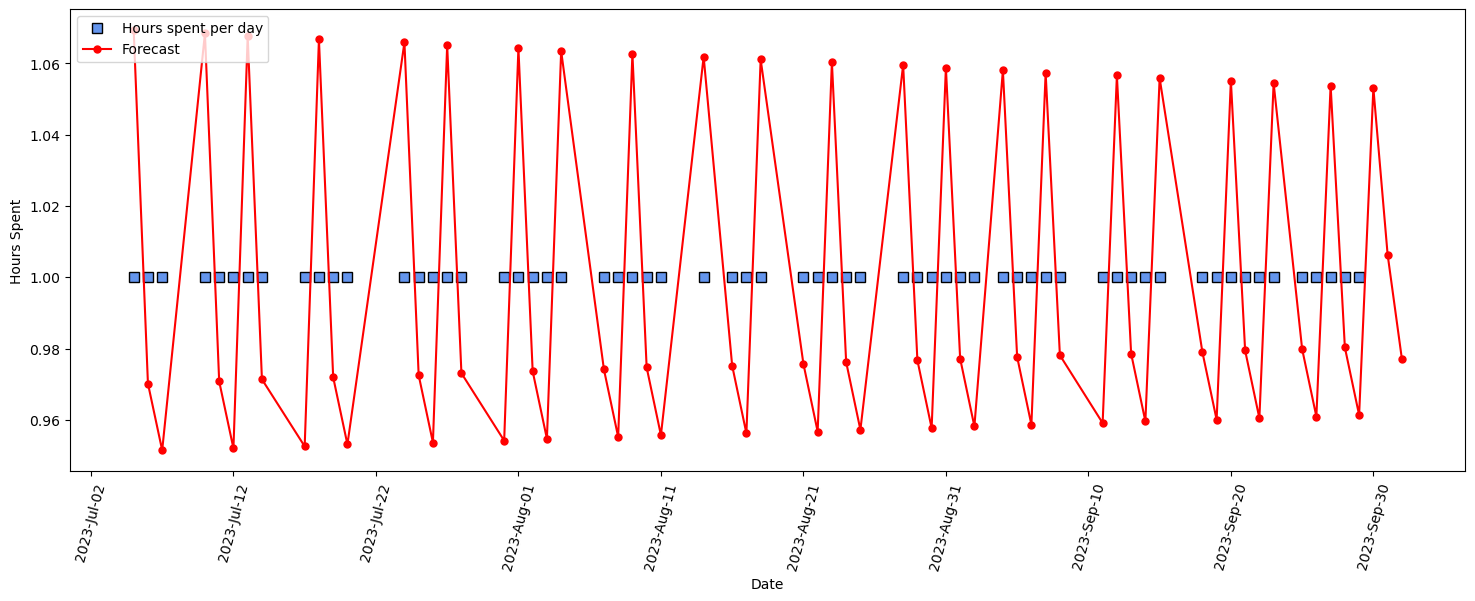

ID9
No seasonality found
Period: 1
Initial Level: 3600.000000000001
Initial Trend: -9.575673587391975e-16
Initial Seasonal: [1]
                  DATE TEAMNAME  USERCOUNT  SECONDSSPENT  QUANTITY  VOLUME  \
2023-09-29  2023-09-29      ID9        0.0        3600.0       0.0     0.0   
2023-09-30         NaN      NaN        NaN           NaN       NaN     NaN   

            WEIGHT  PRICE  FORECAST  
2023-09-29     0.0    0.0    3600.0  
2023-09-30     NaN    NaN    3600.0  
MAE: 0.000


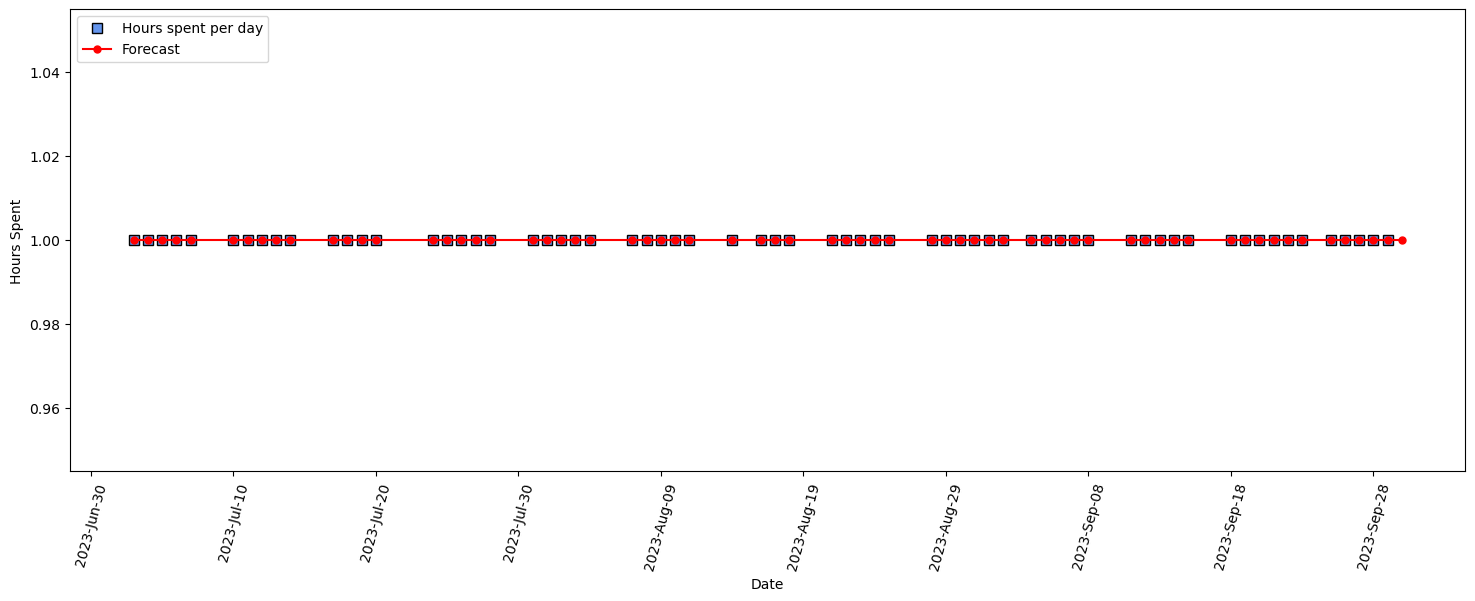

In [320]:
df = pd.read_csv('data/daily.csv')
df.index = pd.to_datetime(df['DATE'])
df = df[df.index > '2022-08-10']
df_multi_index = pd.MultiIndex.from_product([df['DATE'].unique(), df['TEAMNAME'].unique()], names=['DATE', 'TEAMNAME'])
df = df.set_index(['DATE', 'TEAMNAME']).reindex(df_multi_index, fill_value=0).reset_index()
df.index = pd.to_datetime(df['DATE'])
column = 'SECONDSSPENT'
print(0 in df[column].to_list())
for team in df['TEAMNAME'].unique():
    df_team = df[df['TEAMNAME'] == team]
    if len(df_team) > 1:
        print(team)
        plot_forecast(df_team, column, team)